<a href="https://colab.research.google.com/github/danlingzhou16/stat390/blob/GraceZhu/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import keras
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [2]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100
def model_performance(y_true, y_pred):
  rmse = np.sqrt(mean_squared_error(y_true, y_pred))
  mape = MAPE(y_true, y_pred)
  return f"RMSE: {rmse}, MAPE: {mape}"

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [147]:
train = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/train_final.csv', index_col=['date'], parse_dates = ['date'])
test = pd.read_csv('/content/gdrive/MyDrive/complete covid dataset/test_final.csv', index_col=['date'], parse_dates = ['date'])

In [148]:
# Feature Engineering same as for multivariate prophet

In [149]:
train = train[~(train.index < '2020-03-01')]
test = test[~(test.index < '2020-03-01')]

In [150]:
# drop useless columns
train_dropped = train.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'new_confirmed_std1'])
test_dropped = test.drop(columns = ['Unnamed: 0.1', 'Unnamed: 0', 'day_name', 'new_confirmed_mean1', 'new_confirmed_max1', 'new_confirmed_min1', 'new_confirmed_std1'])

In [151]:
train_prepared = train_dropped[[
 'country_code',
 'new_deceased',
 'cumulative_deceased',
 'population',
 'population_male',
 'population_female',
 'area_sq_km',
 'life_expectancy',
 'mobility_workplaces',
 'new_persons_fully_vaccinated',
 'cumulative_persons_fully_vaccinated',
 'new_confirmed',
 'new_confirmed_lag1',
 'new_confirmed_lag3',
 'new_confirmed_lag7',
 'new_confirmed_mean3',
 'new_confirmed_mean7',
 'new_confirmed_std3',
 'new_confirmed_std7',
 'new_confirmed_max3',
 'new_confirmed_max7',
 'new_confirmed_min3',
 'new_confirmed_min7',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'season']]


In [152]:
test_prepared = test_dropped[[
 'country_code',
 'new_deceased',
 'cumulative_deceased',
 'population',
 'population_male',
 'population_female',
 'area_sq_km',
 'life_expectancy',
 'mobility_workplaces',
 'new_persons_fully_vaccinated',
 'cumulative_persons_fully_vaccinated',
 'new_confirmed',
 'new_confirmed_lag1',
 'new_confirmed_lag3',
 'new_confirmed_lag7',
 'new_confirmed_mean3',
 'new_confirmed_mean7',
 'new_confirmed_std3',
 'new_confirmed_std7',
 'new_confirmed_max3',
 'new_confirmed_max7',
 'new_confirmed_min3',
 'new_confirmed_min7',
 'day_of_week',
 'quarter',
 'month',
 'year',
 'dayofyear',
 'dayofmonth',
 'weekofyear',
 'season']]

In [153]:
# one hot encoding
train_prepared = pd.get_dummies(train_prepared, columns=['country_code', 'season'])


In [154]:
test_prepared = pd.get_dummies(test_prepared, columns=['country_code', 'season'])

(array([6.1889e+04, 3.1850e+03, 1.0420e+03, 4.7800e+02, 1.7800e+02,
        9.8000e+01, 9.2000e+01, 4.6000e+01, 3.2000e+01, 2.0000e+01,
        2.1000e+01, 1.8000e+01, 7.0000e+00, 6.0000e+00, 6.0000e+00,
        2.0000e+00, 4.0000e+00, 9.0000e+00, 6.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([    0.        ,  2872.06666667,  5744.13333333,  8616.2       ,
        11488.26666667, 14360.33333333, 17232.4       , 20104.46666667,
        22976.53333333, 25848.6       , 28720.66666667, 31592.73333333,
        34464.8       , 37336.86666667, 40208.93333333, 43081.        ,
        45953.06666667, 48825.13333333, 51697.2       , 54569.26666667,
        57441.33333333, 60313.4       , 63185.46666667, 66057.53333333,
        68929.6       , 71801.66666667, 74673.73333333, 77545.8       ,
        80417.86666667, 83289.93333333, 86162.        ]),
 <BarContainer object of 30 

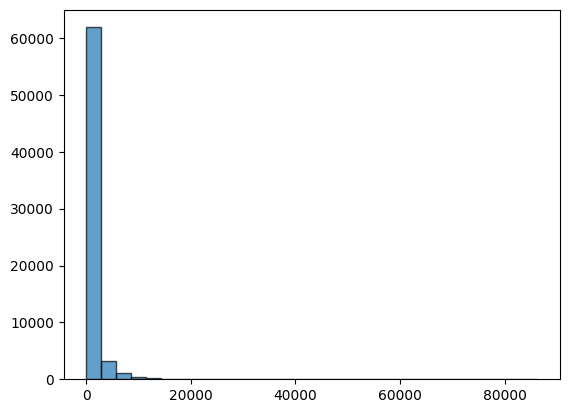

In [155]:
plt.hist(train_prepared.new_confirmed, bins=30, edgecolor='black', alpha=0.7)

In [156]:
train_prepared.isnull().sum().sort_values(ascending = False)

new_confirmed_lag7                     102
new_confirmed_mean7                     66
new_confirmed_max7                      66
new_confirmed_std7                      66
new_confirmed_min7                      66
new_confirmed_lag3                      33
new_confirmed_max3                      22
new_confirmed_min3                      22
new_confirmed_mean3                     22
new_confirmed_std3                      22
new_confirmed_lag1                      11
country_code_US                          0
country_code_AU                          0
country_code_CH                          0
country_code_DK                          0
country_code_IE                          0
season_Summer                            0
season_Autumn                            0
season_Spring                            0
country_code_SG                          0
dayofmonth                               0
country_code_IS                          0
country_code_LU                          0
country_cod

In [157]:
# put zeros to missing lagging features
train_prepared.fillna(0, inplace = True)
test_prepared.fillna(0, inplace = True)

In [158]:
test_prepared.isnull().sum().sort_values(ascending = False)

new_deceased                           0
country_code_IE                        0
month                                  0
year                                   0
dayofyear                              0
dayofmonth                             0
weekofyear                             0
country_code_AU                        0
country_code_CH                        0
country_code_DK                        0
country_code_IS                        0
day_of_week                            0
country_code_LU                        0
country_code_NO                        0
country_code_QA                        0
country_code_SG                        0
country_code_US                        0
season_Autumn                          0
season_Spring                          0
season_Summer                          0
quarter                                0
new_confirmed_min7                     0
cumulative_deceased                    0
new_confirmed                          0
population      

In [159]:
train_prepared.isnull().sum().sort_values(ascending = False)

new_deceased                           0
country_code_IE                        0
month                                  0
year                                   0
dayofyear                              0
dayofmonth                             0
weekofyear                             0
country_code_AU                        0
country_code_CH                        0
country_code_DK                        0
country_code_IS                        0
day_of_week                            0
country_code_LU                        0
country_code_NO                        0
country_code_QA                        0
country_code_SG                        0
country_code_US                        0
season_Autumn                          0
season_Spring                          0
season_Summer                          0
quarter                                0
new_confirmed_min7                     0
cumulative_deceased                    0
new_confirmed                          0
population      

In [160]:
# the data is skewed to the right -> let's do normalization
def normalize(df):
    for col in df.columns:
        if col != 'new_confirmed':
            df[col]=(df[col]-df[col].mean())/df[col].std()
    return df
train_prepared=normalize(train_prepared)


In [161]:
test_prepared=normalize(test_prepared)

In [162]:
def make_series(data):
    series=[]
    for i in range(14, len(data)+1):
        subdf=data[(i-14):i]
        series.append((data.index[i-1], data['new_confirmed'].values[i-1], subdf.drop('new_confirmed', axis=1).values))
    return series

In [163]:
train_prepared=make_series(train_prepared)

In [164]:
test_prepared=make_series(test_prepared)

In [165]:
print(train_prepared[0][0],train_prepared[0][1].shape,train_prepared[0][2].shape)

2020-03-14 00:00:00 () (14, 42)


In [167]:
learning_rate = 0.01
batch_size = 32
epochs = 100
sequence_length =14

In [168]:
inputs = keras.layers.Input(shape=(14,42))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 14, 42)]          0         
                                                                 
 lstm_7 (LSTM)               (None, 32)                9600      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 9633 (37.63 KB)
Trainable params: 9633 (37.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
x=np.array([x[2].reshape(14,42) for x in train_prepared])
y=np.array([x[1] for x in train_prepared])
print(x.shape)
print(y.shape)
history = model.fit(
    x=x,y=y,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
)

(67139, 14, 42)
(67139,)
Epoch 1/100
2099/2099 [==============================] - 18s 8ms/step - loss: 6975523.5000
Epoch 2/100
2099/2099 [==============================] - 16s 8ms/step - loss: 6297558.0000
Epoch 3/100
2099/2099 [==============================] - 16s 8ms/step - loss: 5766721.5000
Epoch 4/100
2099/2099 [==============================] - 17s 8ms/step - loss: 5339324.0000
Epoch 5/100
2099/2099 [==============================] - 17s 8ms/step - loss: 4981050.5000
Epoch 6/100
2099/2099 [==============================] - 16s 8ms/step - loss: 4677814.5000
Epoch 7/100
2099/2099 [==============================] - 16s 8ms/step - loss: 4418370.5000
Epoch 8/100
2099/2099 [==============================] - 16s 8ms/step - loss: 4185919.0000
Epoch 9/100
2099/2099 [==============================] - 17s 8ms/step - loss: 3989523.2500
Epoch 10/100
2099/2099 [==============================] - 16s 8ms/step - loss: 3816238.2500
Epoch 11/100
2099/2099 [==============================] - 16s 8m

In [170]:
train_pred=pd.DataFrame(model.predict(x), columns=['yhat'], index=[x[0] for x in train_prepared ])
train_pred.head()

2099/2099 [==============================] - 6s 3ms/step


,yhat
2020-03-14,-823.790466
2020-03-15,-826.983459
2020-03-16,-709.637878
2020-03-17,-763.710266
2020-03-18,-843.683044


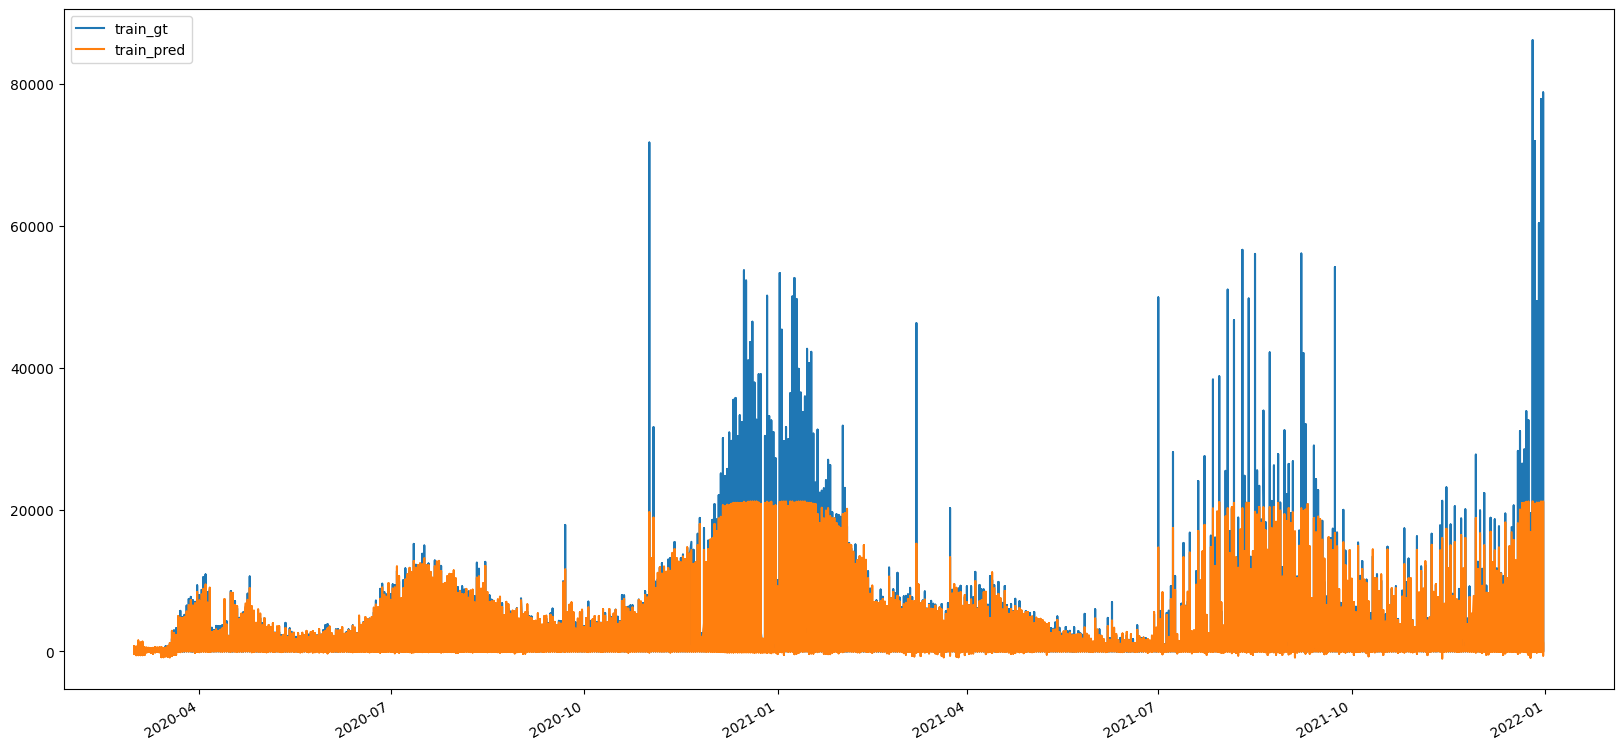

In [171]:
train_gt= pd.DataFrame(y, columns=['y'], index=[x[0] for x in train_prepared ])
pd.concat([train_gt, train_pred], axis=1).plot(figsize=(20,10))
plt.legend(['train_gt', 'train_pred'])

820/820 [==============================] - 3s 4ms/step


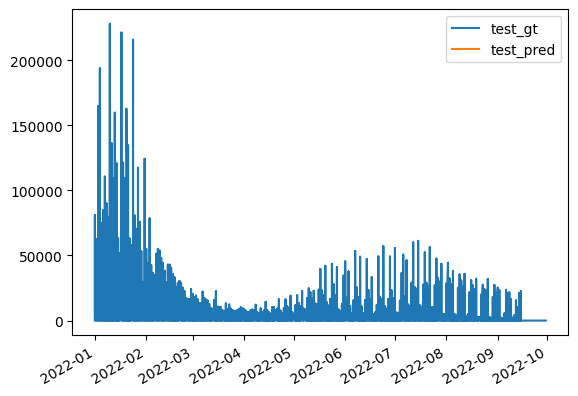

In [177]:
test_pred=model.predict(np.array([x[2].reshape(14,42) for x in test_prepared]))
test_pred=pd.DataFrame(test_pred, columns=['yhat'], index=[x[0] for x in test_prepared ])
test_gt=pd.DataFrame([x[1] for x in test_prepared], columns=['y'], index=[x[0] for x in test_prepared ])
pd.concat([test_gt, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

In [180]:
train_pred

,yhat
2020-03-14,-823.790466
2020-03-15,-826.983459
2020-03-16,-709.637878
2020-03-17,-763.710266
2020-03-18,-843.683044
...,...
2021-12-27,173.265717
2021-12-28,149.339081
2021-12-29,78.461639
2021-12-30,80.154053


In [175]:
model_performance(train_gt, train_pred)

<ipython-input-2-1f5806c96e77>:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true-y_pred)/y_true)) * 100


'RMSE: 1040.431959050048, MAPE: inf'

In [ ]:
model_performance(test_gt, test_pred)